In [ ]:
%matplotlib inline



# Simulate raw data using subject anatomy

This example illustrates how to generate source estimates and simulate raw data
using subject anatomy with the :class:`mne.simulation.SourceSimulator` class.
Once the raw data is simulated, generated source estimates are reconstructed
using dynamic statistical parametric mapping (dSPM) inverse operator.


In [ ]:
!pip3 install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.7 MB/s eta 0:00:00


In [ ]:
import numpy as np

import mne
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


In this example, raw data will be simulated for the sample subject, so its
information needs to be loaded. This step will download the data if it not
already on your machine. Subjects directory is also set so it doesn't need
to be given to functions.



In [ ]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 185GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


First, we get an info structure from the sample subject.



In [ ]:
fname_info = meg_path / 'sample_audvis_raw.fif'
info = mne.io.read_info(fname_info)
tstep = 1 / info['sfreq']

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle


To simulate sources, we also need a source space. It can be obtained from the
forward solution of the sample subject.



In [ ]:
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']

Reading forward solution from /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


To simulate raw data, we need to define when the activity occurs using events
matrix and specify the IDs of each event.
Noise covariance matrix also needs to be defined.
Here, both are loaded from the sample dataset, but they can also be specified
by the user.



In [ ]:
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

events = mne.read_events(fname_event)
noise_cov = mne.read_cov(fname_cov)

# Standard sample event IDs. These values will correspond to the third column
# in the events matrix.
event_id = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
            'visual/right': 4, 'smiley': 5, 'button': 32}


# Take only a few events for speed
events = events[:80]

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active


In order to simulate source time courses, labels of desired active regions
need to be specified for each of the 4 simulation conditions.
Make a dictionary that maps conditions to activation strengths within
aparc.a2009s :footcite:`DestrieuxEtAl2010` labels.
In the aparc.a2009s parcellation:

- 'G_temp_sup-G_T_transv' is the label for primary auditory area
- 'S_calcarine' is the label for primary visual area

In each of the 4 conditions, only the primary area is activated. This means
that during the activations of auditory areas, there are no activations in
visual areas and vice versa.
Moreover, for each condition, contralateral region is more active (here, 2
times more) than the ipsilateral.



In [ ]:
activations = {
    'auditory/left':
        [('G_temp_sup-G_T_transv-lh', 30),          # label, activation (nAm)
         ('G_temp_sup-G_T_transv-rh', 60)],
    'auditory/right':
        [('G_temp_sup-G_T_transv-lh', 60),
         ('G_temp_sup-G_T_transv-rh', 30)],
    'visual/left':
        [('S_calcarine-lh', 30),
         ('S_calcarine-rh', 60)],
    'visual/right':
        [('S_calcarine-lh', 60),
         ('S_calcarine-rh', 30)],
}

annot = 'aparc.a2009s'

# Load the 4 necessary label names.
label_names = sorted(set(activation[0]
                         for activation_list in activations.values()
                         for activation in activation_list))
region_names = list(activations.keys())

## Create simulated source activity

Generate source time courses for each region. In this example, we want to
simulate source activity for a single condition at a time. Therefore, each
evoked response will be parametrized by latency and duration.



In [ ]:
def data_fun(times, latency, duration):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    f = 15  # oscillating frequency, beta band [Hz]
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf

In [ ]:
times = np.arange(150, dtype=np.float64) / info['sfreq']
duration = 0.03
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(2):
        label_name = activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = activations[region_name][i][1]
        if region_name.split('/')[1][0] == label_tmp.hemi[0]:
            latency_tmp = 0.115
        else:
            latency_tmp = 0.1
        wf_tmp = data_fun(times, latency_tmp, duration)
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * wf_tmp,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000-1.665 sec
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec
    Interval 0.000-1.665 sec


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


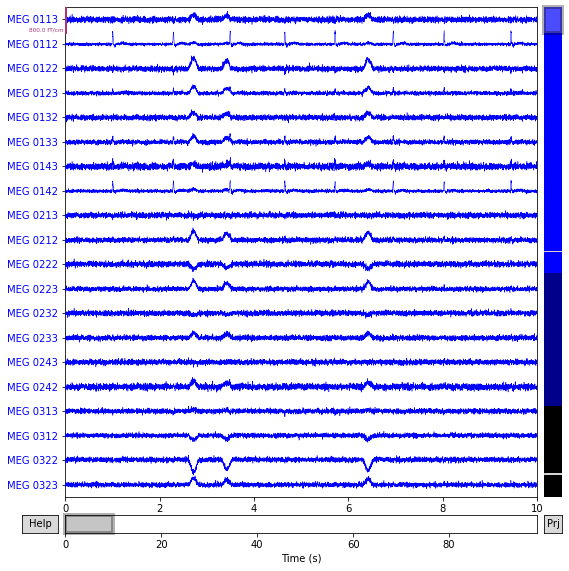

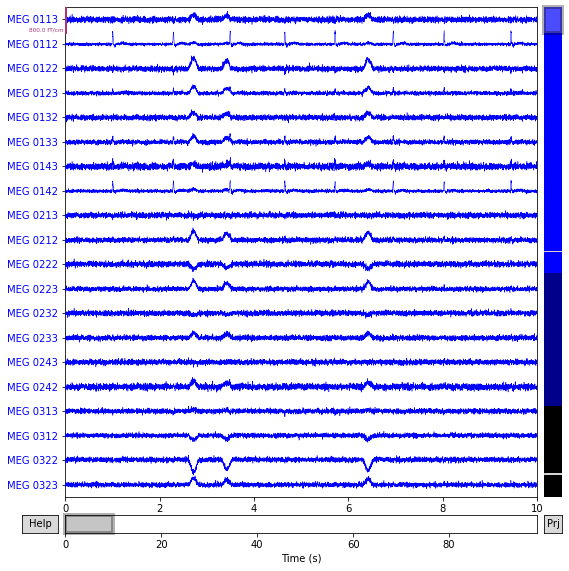

In [ ]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(raw_sim, cov=noise_cov, random_state=0)
mne.simulation.add_eog(raw_sim, random_state=0)
mne.simulation.add_ecg(raw_sim, random_state=0)

# Plot original and simulated raw data.
raw_sim.plot(title='Simulated raw data')

Not setting metadata
80 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated


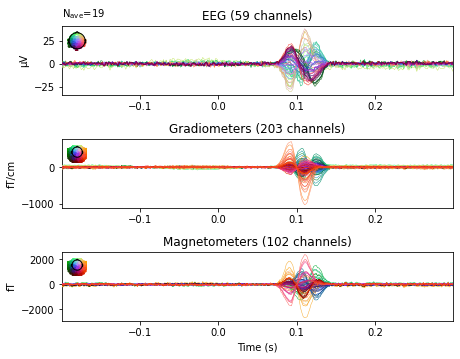

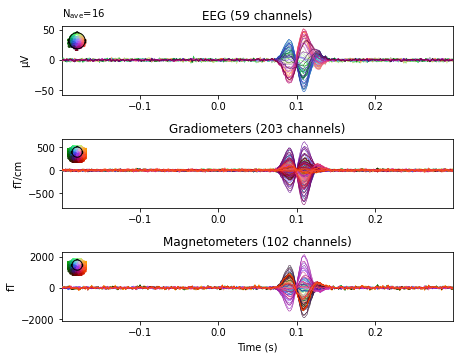

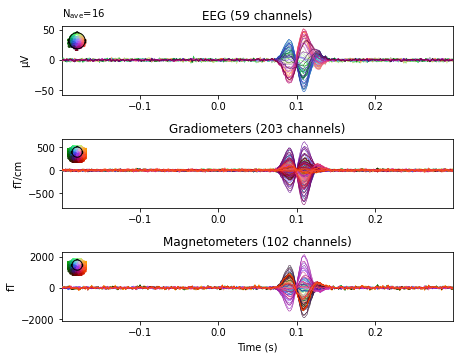

In [ ]:
epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=0.3,
                    baseline=(None, 0))
evoked_aud_left = epochs['auditory/left'].average()
evoked_vis_right = epochs['visual/right'].average()

# Visualize the evoked data
evoked_aud_left.plot(spatial_colors=True)
evoked_vis_right.plot(spatial_colors=True)

In [ ]:
!pip install pyvistaqt
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 8.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00


In [ ]:
method, lambda2 = 'dSPM', 1. / 9.
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)
stc_aud = mne.minimum_norm.apply_inverse(
    evoked_aud_left, inv, lambda2, method)
stc_vis = mne.minimum_norm.apply_inverse(
    evoked_vis_right, inv, lambda2, method)
stc_diff = stc_aud - stc_vis

brain = stc_diff.plot(subjects_dir=subjects_dir, initial_time=0.1,
                      hemi='split', views=['lat', 'med'])

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank=None
    Using tolerance 3.3e-13 (2.2e-16 eps * 305 dim * 4.8  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 4.7e-14 (2.2e-16 eps * 59 dim * 3.6  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1

QtBindingsNotFoundError: ignored